In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
def load_training():
    images = np.load(os.path.join('../Data_final_calcver', 'X_train.npy'))
    labels = np.load(os.path.join('../Data_final_calcver', 'train_calc_labels2_num.npy'))
    return images, labels


def load_testing():
    images = np.load(os.path.join('../Data_final_calcver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_calcver', 'test_calc_labels2_num.npy'))
    return images, labels

In [3]:
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 1546 	 Test size: 326
Image size: 256x256


In [4]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [5]:
train_images.shape

(1546, 256, 256, 1)

In [6]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [7]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [8]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [9]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

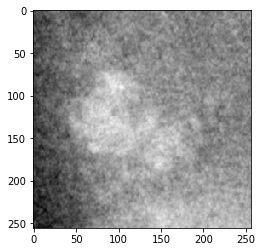

Label: [0. 1.]


In [10]:
idx = 111

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

In [11]:
def create_vgg19(verbose=False, fc_size=256, output = 4, dropout=None):

    vgg19_base = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg19 = models.Sequential()
    vgg19.add(vgg19_base)

    vgg19.add(layers.Flatten())
    if dropout is not None:
        vgg19.add(layers.Dropout(dropout))
    vgg19.add(layers.Dense(1024, activation='relu'))
    vgg19.add(layers.Dense(fc_size, activation='relu'))
    vgg19.add(layers.Dense(output, activation='softmax'))

    # Freeze the convolutional base
    vgg19_base.trainable = False
    
    if verbose:
        vgg19_base.summary()
        vgg19.summary()

    return vgg19

In [12]:
vgg19_calc_benign_or_malignant_best = create_vgg19(dropout=0.5, fc_size=128, output = 2)

In [13]:
vgg19_calc_benign_or_malignant_best.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 53,711,298
Trainable params: 33,686,914
Non-trainable params: 20,024,384
___________________________________

In [14]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_benign_or_malignant_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_benign_or_malignant_best.compile(optimizer=optimizers.RMSprop(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Train
history_vgg19_calc_benign_or_malignant_best = vgg19_calc_benign_or_malignant_best.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6 steps, validate for 3 steps
Epoch 1/300
5/6 [========================>.....] - ETA: 2s - loss: 1.6669 - accuracy: 0.5963
Epoch 00001: val_loss improved from inf to 1.16183, saving model to ../model/vgg19_calc_benign_or_malignant_best.h5
6/6 [==============================] - 21s 3s/step - loss: 1.5995 - accuracy: 0.5931 - val_loss: 1.1618 - val_accuracy: 0.5761
Epoch 2/300
5/6 [========================>.....] - ETA: 1s - loss: 1.1045 - accuracy: 0.6298
Epoch 00002: val_loss improved from 1.16183 to 1.13307, saving model to ../model/vgg19_calc_benign_or_malignant_best.h5
6/6 [==============================] - 12s 2s/step - loss: 1.0987 - accuracy: 0.6290 - val_loss: 1.1331 - val_accuracy: 0.5955
Epoch 3/300
5/6 [========================>.....] - ETA: 1s - loss: 1.0886 - accuracy: 0.6131
Epoch 00003: val_loss improved from 1.13307 to 0.97675, saving mo

Epoch 28/300
5/6 [========================>.....] - ETA: 1s - loss: 0.6582 - accuracy: 0.7002
Epoch 00028: val_loss did not improve from 0.66675
6/6 [==============================] - 13s 2s/step - loss: 0.6585 - accuracy: 0.6952 - val_loss: 0.8127 - val_accuracy: 0.6214
Epoch 29/300
5/6 [========================>.....] - ETA: 1s - loss: 0.6831 - accuracy: 0.7102
Epoch 00029: val_loss did not improve from 0.66675
6/6 [==============================] - 13s 2s/step - loss: 0.6836 - accuracy: 0.7007 - val_loss: 0.7731 - val_accuracy: 0.6602
Epoch 30/300
5/6 [========================>.....] - ETA: 1s - loss: 0.6637 - accuracy: 0.7203
Epoch 00030: val_loss did not improve from 0.66675
6/6 [==============================] - 13s 2s/step - loss: 0.6840 - accuracy: 0.7186 - val_loss: 0.7858 - val_accuracy: 0.6472
Epoch 31/300
5/6 [========================>.....] - ETA: 1s - loss: 0.7070 - accuracy: 0.7219
Epoch 00031: val_loss did not improve from 0.66675
6/6 [==============================] - 

Epoch 58/300
5/6 [========================>.....] - ETA: 1s - loss: 0.6263 - accuracy: 0.7250
Epoch 00058: val_loss did not improve from 0.61758
6/6 [==============================] - 13s 2s/step - loss: 0.6205 - accuracy: 0.7174 - val_loss: 0.6534 - val_accuracy: 0.6699
Epoch 59/300
5/6 [========================>.....] - ETA: 1s - loss: 0.5623 - accuracy: 0.7297
Epoch 00059: val_loss did not improve from 0.61758
6/6 [==============================] - 13s 2s/step - loss: 0.5650 - accuracy: 0.7305 - val_loss: 0.6720 - val_accuracy: 0.6408
Epoch 60/300
5/6 [========================>.....] - ETA: 1s - loss: 0.5409 - accuracy: 0.7270
Epoch 00060: val_loss did not improve from 0.61758
6/6 [==============================] - 13s 2s/step - loss: 0.5429 - accuracy: 0.7338 - val_loss: 0.6524 - val_accuracy: 0.6472
Epoch 61/300
5/6 [========================>.....] - ETA: 1s - loss: 0.6325 - accuracy: 0.6984
Epoch 00061: val_loss did not improve from 0.61758
6/6 [==============================] - 

5/6 [========================>.....] - ETA: 1s - loss: 0.6024 - accuracy: 0.7063
Epoch 00087: val_loss did not improve from 0.57972
6/6 [==============================] - 13s 2s/step - loss: 0.5916 - accuracy: 0.7090 - val_loss: 0.6179 - val_accuracy: 0.6570
Epoch 88/300
5/6 [========================>.....] - ETA: 1s - loss: 0.5358 - accuracy: 0.7469
Epoch 00088: val_loss did not improve from 0.57972
6/6 [==============================] - 12s 2s/step - loss: 0.5402 - accuracy: 0.7357 - val_loss: 0.6672 - val_accuracy: 0.6117
Epoch 89/300
5/6 [========================>.....] - ETA: 1s - loss: 0.5832 - accuracy: 0.7353
Epoch 00089: val_loss did not improve from 0.57972
6/6 [==============================] - 13s 2s/step - loss: 0.5859 - accuracy: 0.7283 - val_loss: 0.5934 - val_accuracy: 0.6570
Epoch 90/300
5/6 [========================>.....] - ETA: 1s - loss: 0.5945 - accuracy: 0.7063
Epoch 00090: val_loss did not improve from 0.57972
6/6 [==============================] - 12s 2s/step -

Epoch 117/300
5/6 [========================>.....] - ETA: 1s - loss: 0.5321 - accuracy: 0.7236
Epoch 00117: val_loss did not improve from 0.57924
6/6 [==============================] - 12s 2s/step - loss: 0.5339 - accuracy: 0.7255 - val_loss: 0.5962 - val_accuracy: 0.6537
Epoch 118/300
5/6 [========================>.....] - ETA: 1s - loss: 0.5012 - accuracy: 0.7605
Epoch 00118: val_loss did not improve from 0.57924
6/6 [==============================] - 13s 2s/step - loss: 0.5190 - accuracy: 0.7545 - val_loss: 0.6134 - val_accuracy: 0.6181
Epoch 119/300
5/6 [========================>.....] - ETA: 1s - loss: 0.5238 - accuracy: 0.7109
Epoch 00119: val_loss did not improve from 0.57924
6/6 [==============================] - 12s 2s/step - loss: 0.5255 - accuracy: 0.7159 - val_loss: 0.6240 - val_accuracy: 0.6375
Epoch 120/300
5/6 [========================>.....] - ETA: 1s - loss: 0.5091 - accuracy: 0.7344
Epoch 00120: val_loss improved from 0.57924 to 0.57741, saving model to ../model/vgg19

5/6 [========================>.....] - ETA: 1s - loss: 0.5195 - accuracy: 0.7370
Epoch 00146: val_loss did not improve from 0.56098
6/6 [==============================] - 12s 2s/step - loss: 0.5234 - accuracy: 0.7324 - val_loss: 0.5632 - val_accuracy: 0.6537
Epoch 147/300
5/6 [========================>.....] - ETA: 1s - loss: 0.5124 - accuracy: 0.7391
Epoch 00147: val_loss did not improve from 0.56098
6/6 [==============================] - 13s 2s/step - loss: 0.5081 - accuracy: 0.7383 - val_loss: 0.6466 - val_accuracy: 0.6375
Epoch 148/300
5/6 [========================>.....] - ETA: 1s - loss: 0.5130 - accuracy: 0.7337
Epoch 00148: val_loss did not improve from 0.56098
6/6 [==============================] - 13s 2s/step - loss: 0.5009 - accuracy: 0.7407 - val_loss: 0.6018 - val_accuracy: 0.6634
Epoch 149/300
5/6 [========================>.....] - ETA: 1s - loss: 0.5438 - accuracy: 0.7344
Epoch 00149: val_loss did not improve from 0.56098
6/6 [==============================] - 12s 2s/ste

In [16]:
models.save_model(vgg19_calc_benign_or_malignant_best, '../model/vgg19_calc_benign_or_malignant_end.h5')

In [17]:
tra_loss_fe = history_vgg19_calc_benign_or_malignant_best.history['loss']
tra_acc_fe = history_vgg19_calc_benign_or_malignant_best.history['accuracy']
val_loss_fe = history_vgg19_calc_benign_or_malignant_best.history['val_loss']
val_acc_fe = history_vgg19_calc_benign_or_malignant_best.history['val_accuracy']

In [18]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_benign_or_malignant = models.load_model('../model/vgg19_calc_benign_or_malignant_best.h5')
test_loss_fe, test_acc_fe = vgg19_calc_benign_or_malignant_best.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

In [19]:
print("VGG19 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 benign or malignant

Epoch [end]: 166
Epoch [opt]: 136
Valid accuracy [end]: 0.6537
Valid accuracy [opt]: 0.6731
Test accuracy [end]:  0.6442
Test accuracy [opt]:  0.6442
Valid loss [end]: 0.6016
Valid loss [opt]: 0.5610
Test loss [end]:  0.6259
Test loss [opt]:  0.6247


#### fine tuning

In [20]:
vgg19_calc_benign_or_malignant_1 = models.load_model('../model/vgg19_calc_benign_or_malignant_best.h5')

for layer in vgg19_calc_benign_or_malignant_1.get_layer('vgg19').layers:
    if layer.name.startswith('block5_conv4'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_calc_benign_or_malignant_1.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

vgg19_calc_benign_or_malignant_1.summary()
vgg19_calc_benign_or_malignant_1.get_layer('vgg19').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 53,711,298
Trainable params: 36,046,722
Non-trainable params: 17,664,576
___________________________________

In [21]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg19_calc_benign_or_malignant_1_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [22]:
history_fit = vgg19_calc_benign_or_malignant_1.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6 steps, validate for 3 steps
Epoch 1/300
5/6 [========================>.....] - ETA: 1s - loss: 1.3151 - accuracy: 0.7085
Epoch 00001: val_loss improved from inf to 0.60710, saving model to ../model/vgg19_calc_benign_or_malignant_1_best.h5
6/6 [==============================] - 13s 2s/step - loss: 1.1890 - accuracy: 0.6979 - val_loss: 0.6071 - val_accuracy: 0.6246
Epoch 2/300
5/6 [========================>.....] - ETA: 1s - loss: 0.5506 - accuracy: 0.7270
Epoch 00002: val_loss did not improve from 0.60710
6/6 [==============================] - 13s 2s/step - loss: 0.5753 - accuracy: 0.7241 - val_loss: 0.6295 - val_accuracy: 0.6505
Epoch 3/300
5/6 [========================>.....] - ETA: 1s - loss: 0.5534 - accuracy: 0.7344
Epoch 00003: val_loss did not improve from 0.60710
6/6 [==============================] - 13s 2s/step - loss: 0.5526 - accuracy: 0.7393 - val_loss: 0.6268 - val_accuracy: 0.6602
Epoch 4/300
5/6 [=============

Epoch 30/300
5/6 [========================>.....] - ETA: 1s - loss: 0.4312 - accuracy: 0.7906
Epoch 00030: val_loss did not improve from 0.56743
6/6 [==============================] - 13s 2s/step - loss: 0.4254 - accuracy: 0.7890 - val_loss: 0.6527 - val_accuracy: 0.6667
Epoch 31/300
5/6 [========================>.....] - ETA: 1s - loss: 0.4604 - accuracy: 0.7641
Epoch 00031: val_loss did not improve from 0.56743
6/6 [==============================] - 14s 2s/step - loss: 0.4756 - accuracy: 0.7526 - val_loss: 0.6548 - val_accuracy: 0.6278
Epoch 32/300
5/6 [========================>.....] - ETA: 1s - loss: 0.4953 - accuracy: 0.7594
Epoch 00032: val_loss did not improve from 0.56743
6/6 [==============================] - 12s 2s/step - loss: 0.4826 - accuracy: 0.7591 - val_loss: 0.6944 - val_accuracy: 0.6440
Epoch 33/300
5/6 [========================>.....] - ETA: 1s - loss: 0.4362 - accuracy: 0.7538
Epoch 00033: val_loss did not improve from 0.56743
6/6 [==============================] - 

In [23]:
models.save_model(vgg19_calc_benign_or_malignant_1, '../model/vgg19_calc_benign_or_malignant_1_best.h5')

In [24]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['accuracy']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_calc_benign_or_malignant_1 = models.load_model('../model/vgg19_calc_benign_or_malignant_1_best.h5')
test_loss_fe, test_acc_fe = vgg19_calc_benign_or_malignant_1.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_benign_or_malignant_1.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning

Epoch [end]: 47
Epoch [opt]: 17
Valid accuracy [end]: 0.6505
Valid accuracy [opt]: 0.6699
Test accuracy [end]:  0.6963
Test accuracy [opt]:  0.6963
Valid loss [end]: 0.7872
Valid loss [opt]: 0.5674
Test loss [end]:  0.6293
Test loss [opt]:  0.6293


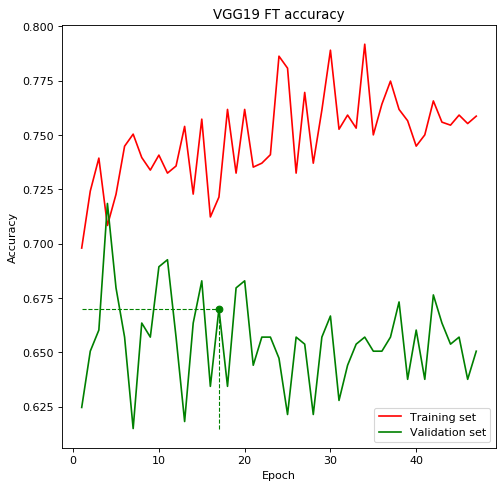

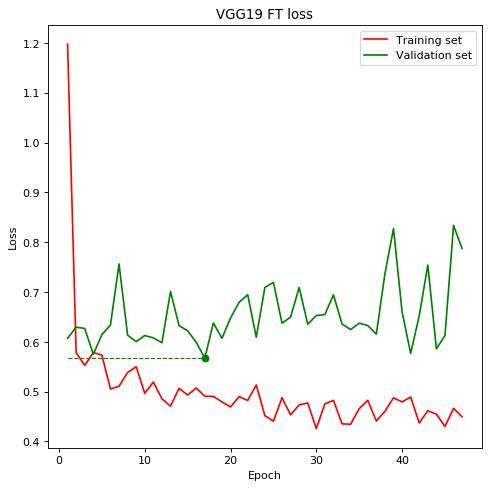

In [25]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();